In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import joblib
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC  # Usamos LinearSVC para SVM, más eficiente que SVC para texto
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

Descargar recursos de NLTK (Natural Language Toolkit)

Este recurso lo usamos para realizar tareas de procesamiento de lenguaje natural (NLP) que son esenciales para preparar el texto del dataset antes del análisis y la construcción del modelo de clasificación 

In [37]:
nltk.download('punkt') # modelo para tokenizacion
nltk.download('punkt_tab')
nltk.download('stopwords') # lista de palabras comunes en ingles
nltk.download('wordnet') # base de datos lexica para lematizacion

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Cargar los datos

In [38]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Exploración inicial del dataset

In [39]:
train_df

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Distribución de clases:

    1 = World 
    2 = Sports
    3 = Business
    4 = Sci/Tech

In [41]:
train_df['Class Index'].value_counts()

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

Mapear los índices de clase a nombres para mejor interpretación

In [42]:
class_mapping = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
train_df['Class Name'] = train_df['Class Index'].map(class_mapping)
test_df['Class Name'] = test_df['Class Index'].map(class_mapping)

Visualización de la distribución de clases

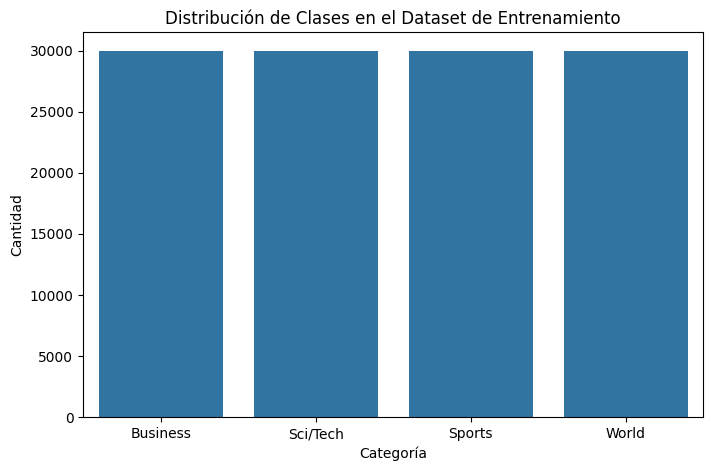

In [43]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Class Name', data=train_df)
plt.title('Distribución de Clases en el Dataset de Entrenamiento')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.show()

Análisis de longitud de los textos

In [44]:
train_df['Text'] = train_df['Title'] + ' ' + train_df['Description']
test_df['Text'] = test_df['Title'] + ' ' + test_df['Description']

In [45]:
test_text = "This is a sample text"
print(word_tokenize(test_text))

['This', 'is', 'a', 'sample', 'text']


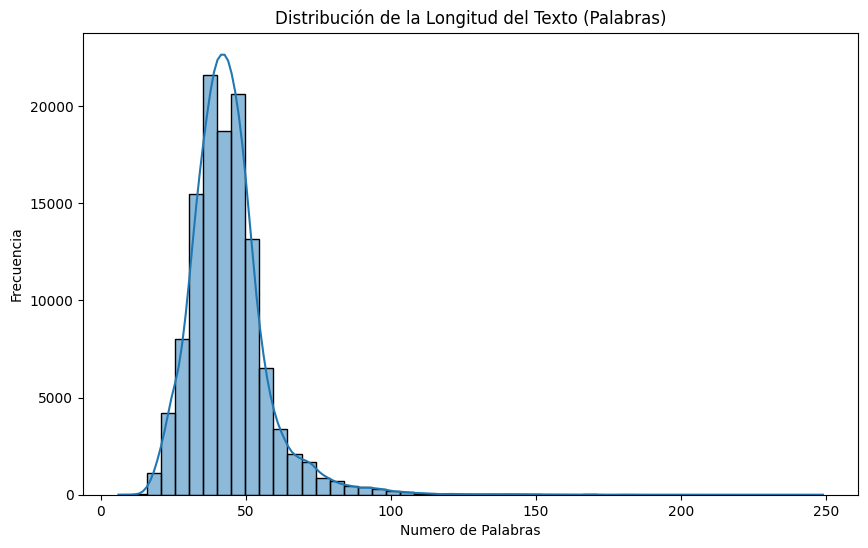

In [46]:
train_df['Text Length'] = train_df['Text'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Text Length'], bins=50, kde=True)
plt.title('Distribución de la Longitud del Texto (Palabras)')
plt.xlabel('Numero de Palabras')
plt.ylabel('Frecuencia')
plt.show()

Palabras más frecuentes por categoría

In [47]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convertir a minúsculas y eliminar caracteres especiales
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar stop words y lematizar
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

Aplicar preprocesamiento y obtener palabras más frecuentes por categoría


=== Palabras más frecuentes en World ===
[('said', 7661), ('39s', 6591), ('u', 6298), ('iraq', 5826), ('ap', 5754), ('reuters', 5405), ('president', 4271), ('minister', 3574), ('new', 3452), ('afp', 3383)]


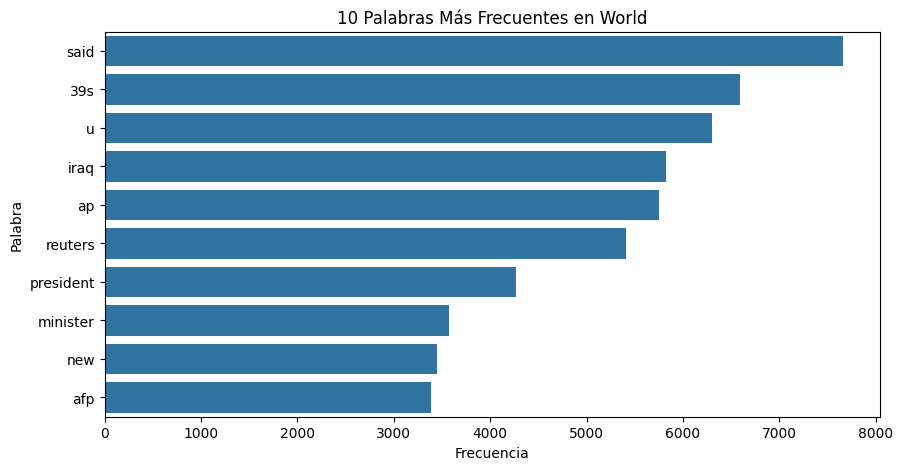


=== Palabras más frecuentes en Sports ===
[('39s', 9541), ('ap', 6247), ('game', 5302), ('win', 4335), ('new', 4109), ('team', 4028), ('first', 3905), ('season', 3392), ('night', 3111), ('world', 3002)]


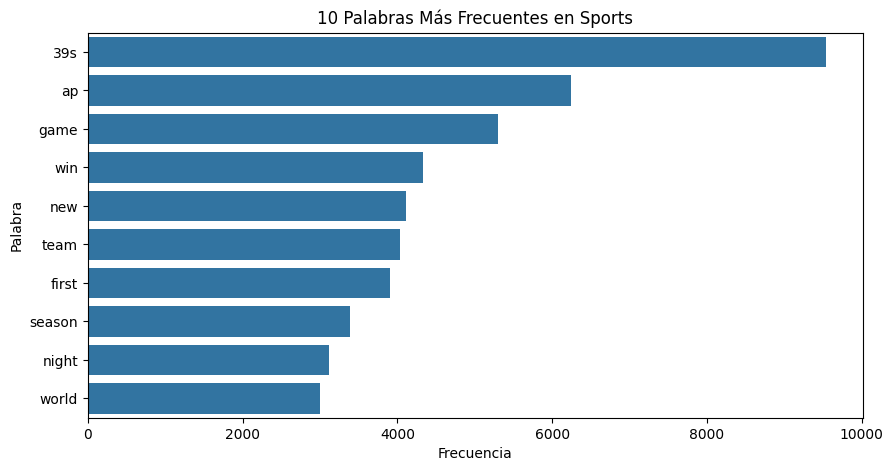


=== Palabras más frecuentes en Business ===
[('39s', 8974), ('u', 8820), ('said', 7230), ('reuters', 6897), ('new', 6556), ('oil', 6246), ('company', 5423), ('price', 5278), ('inc', 4374), ('stock', 4262)]


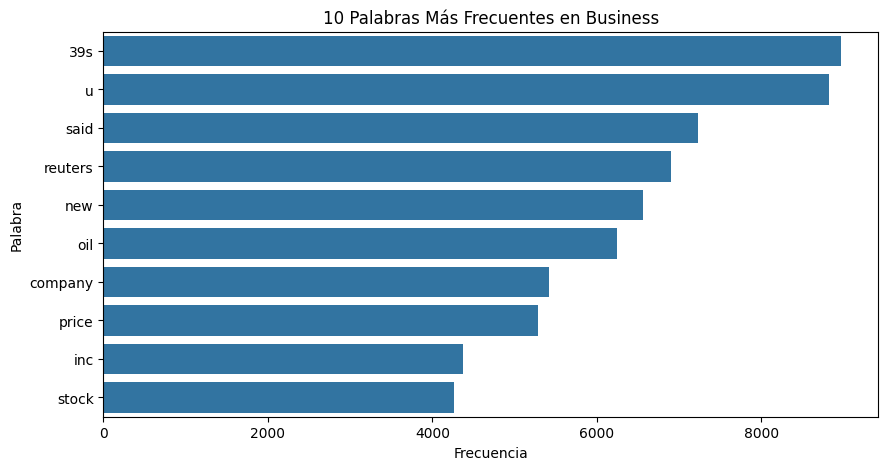


=== Palabras más frecuentes en Sci/Tech ===
[('new', 7093), ('39s', 6112), ('microsoft', 4823), ('company', 4094), ('ap', 3681), ('said', 3603), ('software', 3595), ('service', 3352), ('reuters', 3263), ('internet', 3224)]


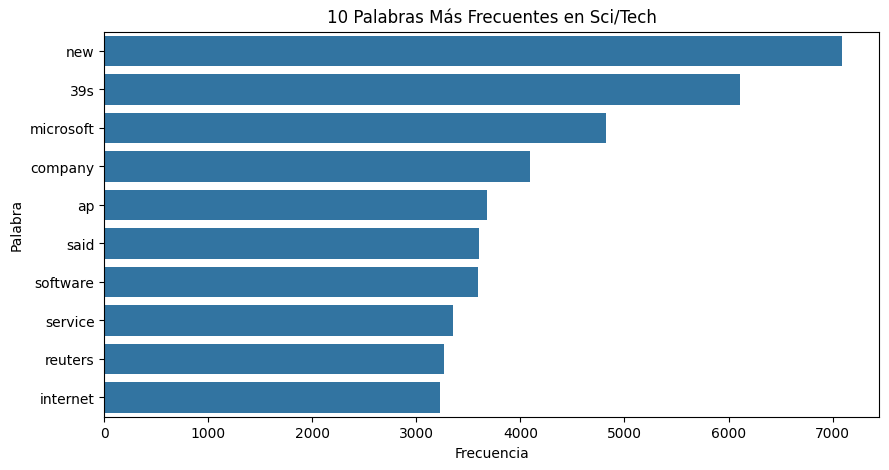

In [48]:
for category in class_mapping.values():
    category_texts = train_df[train_df['Class Name'] == category]['Text']
    all_words = []
    for text in category_texts:
        all_words.extend(preprocess_text(text))
    word_freq = Counter(all_words).most_common(10)
    print(f"\n=== Palabras más frecuentes en {category} ===")
    print(word_freq)
    
    words, counts = zip(*word_freq)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'10 Palabras Más Frecuentes en {category}')
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.show()

## Preprocesamiento para el modelo

this is a text = text

In [49]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])
    return text

se reduce el peso de las palabras que aparecen en muchos documentos (como "this", "is"), ya que son menos informativas, y aumenta el peso de palabras raras que podrían ser más relevantes para una categoría específica (como sports o tech)

In [50]:
train_df['Cleaned Text'] = train_df['Text'].apply(clean_text)
test_df['Cleaned Text'] = test_df['Text'].apply(clean_text)

### Vectorización con TF-IDF

se utiliza para convertir texto en representaciones numéricas que un modelo de aprendizaje automático pueda procesar

In [51]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['Cleaned Text'])
y_train = train_df['Class Index']
X_test = vectorizer.transform(test_df['Cleaned Text'])
y_test = test_df['Class Index']

## Entrenar los modelos

In [52]:
def get_metrics(y_true, y_pred, average='weighted'):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average=average),
        'Recall': recall_score(y_true, y_pred, average=average),
        'F1-score': f1_score(y_true, y_pred, average=average)
    }

results = {}


### modelo de Logistic Regression

In [64]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred, target_names=class_mapping.values(), output_dict=True)
training_time = 0 

results["Logistic Regression"] = {
    'precision': report['weighted avg']['precision'],
    'recall': report['weighted avg']['recall'],
    'f1-score': report['weighted avg']['f1-score'],
    'training_time': training_time
}

Matriz de confusión

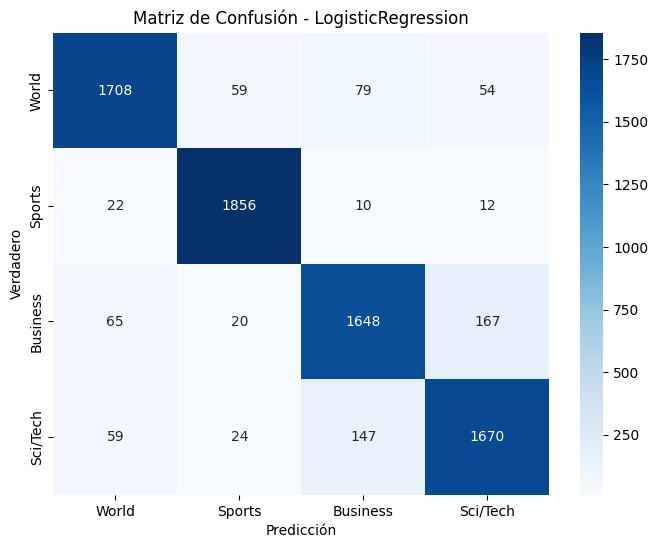

In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.title('Matriz de Confusión - LogisticRegression')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

In [55]:
joblib.dump(model, 'Logistic_Regression.pkl')

['Logistic_Regression.pkl']

In [56]:
results = {}

def train_and_evaluate(model, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=class_mapping.values(), output_dict=True)
    
    results[model_name] = {
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score'],
        'training_time': training_time
    }
    
    print(f"\n=== Resultados de {model_name} ===")
    print(classification_report(y_test, y_pred, target_names=class_mapping.values()))
    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

### Entrenar el modelo de Random Forest

In [57]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate(rf_model, "Random Forest")


=== Resultados de Random Forest ===
              precision    recall  f1-score   support

       World       0.90      0.89      0.89      1900
      Sports       0.91      0.97      0.94      1900
    Business       0.86      0.84      0.85      1900
    Sci/Tech       0.87      0.85      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Tiempo de entrenamiento: 353.04 segundos


### Entrenar el modelo SVM (LinearSVC)

SVM (usamos LinearSVC para mejor rendimiento con datos sparse como TF-IDF)

In [58]:
svm_model = LinearSVC(max_iter=1000)
train_and_evaluate(svm_model, "SVM (LinearSVC)")


=== Resultados de SVM (LinearSVC) ===
              precision    recall  f1-score   support

       World       0.93      0.90      0.91      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.87      0.87      0.87      1900
    Sci/Tech       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

Tiempo de entrenamiento: 3.40 segundos


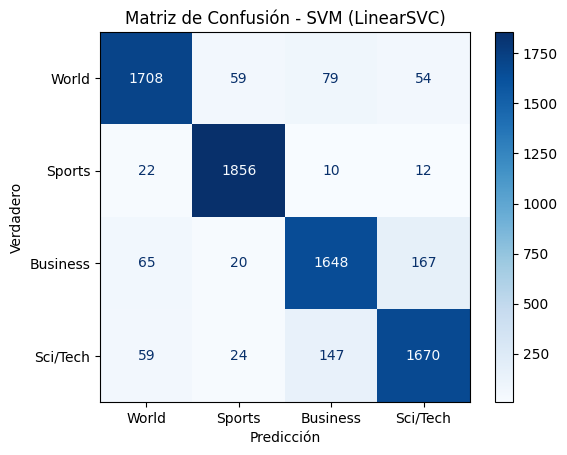

In [59]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_mapping.values())
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - SVM (LinearSVC)")
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

### Entrenar el modelo XGBoost
Ajustamos las etiquetas porque XGBoost espera clases que empiecen desde 0

In [60]:
# codificar
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# entrenar
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
start_time = time.time()
xgb_model.fit(X_train, y_train_encoded)
training_time = time.time() - start_time

# predecir
y_pred_encoded = xgb_model.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

print(f"Training time: {training_time:.2f} seconds")
print(classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, target_names=class_mapping.values(), output_dict=True)

results["XGBoost"] = {
    'precision': report['weighted avg']['precision'],
    'recall': report['weighted avg']['recall'],
    'f1-score': report['weighted avg']['f1-score'],
    'training_time': training_time
}

c:\Users\ASUS\Desktop\demo_moelos_clasificacion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:05:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time: 185.65 seconds
              precision    recall  f1-score   support

           1       0.91      0.89      0.90      1900
           2       0.92      0.95      0.94      1900
           3       0.87      0.85      0.86      1900
           4       0.85      0.85      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



### Entrenar el modelo LightGBM
Ajustamos las etiquetas porque LightGBM también espera clases que empiecen desde 0

In [61]:
lgbm_model = LGBMClassifier(random_state=42)
train_and_evaluate(lgbm_model, "LightGBM")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.389288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488096
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 5000
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294

=== Resultados de LightGBM ===
              precision    recall  f1-score   support

       World       0.91      0.90      0.90      1900
      Sports       0.93      0.96      0.95      1900
    Business       0.87      0.86      0.86      1900
    Sci/Tech       0.87      0.86      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg  

c:\Users\ASUS\Desktop\demo_moelos_clasificacion\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Comparar Resultados

In [65]:
df_results = pd.DataFrame(results).T
print("\n=== Comparación de Modelos ===")
print(df_results.round(3))


=== Comparación de Modelos ===
                     precision  recall  f1-score  training_time
Random Forest            0.885   0.886     0.885        353.040
SVM (LinearSVC)          0.906   0.906     0.906          3.404
XGBoost                  0.887   0.888     0.888        185.648
LightGBM                 0.894   0.894     0.894         78.610
Logistic Regression      0.905   0.906     0.905          0.000
